# Particle spray algorithm by Chen et al. (2024) via `agama`

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `agama`. This implementation is based on Eugene Vasiliev's [tutorial notebook](https://github.com/GalacticDynamics-Oxford/Agama/blob/master/py/tutorial_streams.ipynb) during the [Streams24](https://stellarstreams.org/streams24/) workshop at Durham.

In [1]:
import agama
agama.setUnits(length=1, velocity=1, mass=1)

timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
print('time unit: %.3f Gyr' % timeUnitGyr)

time unit: 0.978 Gyr


In [2]:
agama.getUnits()

{'length': 1.0, 'velocity': 1.0, 'time': 977.792221683525, 'mass': 1.0}

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Galactic, ICRS, CartesianRepresentation

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem
from gala.potential import CCompositePotential


import pandas as pd

import h5py
import ffmpeg

#Reading GD1 data
df_desi = pd.read_csv('/Users/bsegovia/Downloads/brigette_code/GD-1/GD-1/All_table_at_fig4b_cleaned_copy.csv')


## First, define the particle spray methods

In [4]:
# Useful utility functions

def get_rot_mat(x, y, z, vx, vy, vz):
    # ang. momentum is the cross product of pos. and vel. 
    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    Lz = x * vy - y * vx
    r = (x*x + y*y + z*z)**0.5 # radial distance
    L = (Lx*Lx + Ly*Ly + Lz*Lz)**0.5 # magnitude angular momentum 
    # rotation matrices transforming from the host to the satellite frame for each point on the trajectory
    R = np.zeros((len(x), 3, 3))
    R[:,0,0] = x/r # first row has normalized x, y, z
    R[:,0,1] = y/r
    R[:,0,2] = z/r
    R[:,2,0] = Lx/L #third row has normalized Lx, Ly, Lz
    R[:,2,1] = Ly/L
    R[:,2,2] = Lz/L
    # second row is computed using cross product of first and second row
    R[:,1,0] = R[:,0,2] * R[:,2,1] - R[:,0,1] * R[:,2,2] 
    R[:,1,1] = R[:,0,0] * R[:,2,2] - R[:,0,2] * R[:,2,0]
    R[:,1,2] = R[:,0,1] * R[:,2,0] - R[:,0,0] * R[:,2,1]
    return R, L, r # Return the rotation matrix, angular momentum magnitude L, and radial distance

def get_d2Phi_dr2(pot_host, x, y, z):
    # compute  the second derivative of potential by spherical radius
    r = (x*x + y*y + z*z)**0.5  
    der = pot_host.forceDeriv(np.column_stack([x,y,z]))[1]
    d2Phi_dr2 = -(x**2  * der[:,0] + y**2  * der[:,1] + z**2  * der[:,2] +
                  2*x*y * der[:,3] + 2*y*z * der[:,4] + 2*z*x * der[:,5]) / r**2
    return d2Phi_dr2 




In [5]:
def create_ic_chen24(rng, pot_host, orb_sat, mass_sat):
    N = len(orb_sat)
    x, y, z, vx, vy, vz = orb_sat.T
    R, L, r = get_rot_mat(x, y, z, vx, vy, vz)
    d2Phi_dr2 = get_d2Phi_dr2(pot_host, x, y, z)
    
    # compute the tidal radius at this radius for each point on the trajectory
    Omega = L / r**2
    r_tidal = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)
    
    # assign positions and velocities (in the satellite reference frame) of particles
    r_tidal = np.repeat(r_tidal, 2)

    mean = np.array([1.6, -30, 0, 1, 20, 0])

    cov = np.array([
        [0.1225,   0,   0, 0, -4.9,   0],
        [     0, 529,   0, 0,    0,   0],
        [     0,   0, 144, 0,    0,   0],
        [     0,   0,   0, 0,    0,   0],
        [  -4.9,   0,   0, 0,  400,   0],
        [     0,   0,   0, 0,    0, 484],
    ])
    
    posvel = rng.multivariate_normal(mean, cov, size=2*N)

    Dr = posvel[:, 0] * r_tidal
    v_esc = np.sqrt(2 * agama.G * mass_sat / Dr)
    Dv = posvel[:, 3] * v_esc

    # convert degrees to radians
    phi = posvel[:, 1] * np.pi / 180
    theta = posvel[:, 2] * np.pi / 180
    alpha = posvel[:, 4] * np.pi / 180
    beta = posvel[:, 5] * np.pi / 180

    dx = Dr * np.cos(theta) * np.cos(phi)
    dy = Dr * np.cos(theta) * np.sin(phi)
    dz = Dr * np.sin(theta)
    dvx = Dv * np.cos(beta) * np.cos(alpha)
    dvy = Dv * np.cos(beta) * np.sin(alpha)
    dvz = Dv * np.sin(beta)

    dq = np.column_stack([dx, dy, dz])
    dp = np.column_stack([dvx, dvy, dvz])
    
    ic_stream = np.tile(orb_sat, 2).reshape(2*N, 6)
    
    # trailing arm
    ic_stream[::2,0:3] += np.einsum('ni,nij->nj', dq[::2], R)
    ic_stream[::2,3:6] += np.einsum('ni,nij->nj', dp[::2], R)
    
    # leading arm
    ic_stream[1::2,0:3] += np.einsum('ni,nij->nj', -dq[1::2], R)
    ic_stream[1::2,3:6] += np.einsum('ni,nij->nj', -dp[1::2], R)

    return ic_stream

In [6]:
def create_stream(create_ic_method, rng, time_total, num_particles, pot_host, posvel_sat, mass_sat, pot_sat=None, **kwargs):
    # runs like agama if negative time step is inputted.
    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at num_steps points
    time_sat, orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat,
        time=time_total, trajsize=num_particles//2)
    if time_total < 0:
        # reverse the arrays to make them increasing in time
        time_sat  = time_sat [::-1]
        orbit_sat = orbit_sat[::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at Lagrange points
    ic_stream = create_ic_method(rng, pot_host, orbit_sat, mass_sat, **kwargs)
    
    time_seed = np.repeat(time_sat, 2)
    # time_seed = time_sat
    
    if pot_sat is None:
        pot_tot = pot_host
    else:
        # include the progenitor's potential
        traj = np.column_stack([time_sat, orbit_sat])
        pot_traj = agama.Potential(potential=pot_sat, center=traj)
        pot_tot = agama.Potential(pot_host, pot_traj)
        
    xv_stream = np.vstack(agama.orbit(potential=pot_tot,
        ic=ic_stream, time=-time_seed if time_total<0 else time_total-time_seed, timestart=time_seed, trajsize=1)[:,1])
    
    
    return time_sat, orbit_sat, xv_stream, ic_stream, traj

In [7]:
def create_stream_with_perturber(create_ic_method, rng, time_total, num_particles, pot_host, posvel_sat, posvel_pert, prog_mass, perturber_mass, pot_sat=None, pot_pert = None, **kwargs):

    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at num_steps points
    time_sat, orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat,
        time=time_total, trajsize=num_particles//2)
    if time_total < 0:
        # reverse the arrays to make them increasing in time
        time_sat  = time_sat [::-1]
        orbit_sat = orbit_sat[::-1]

    # the initial position should be the location for pert near prog. 

    # DO THE SAME THING FOR THE PERTURBER
    time_pert, orbit_pert = agama.orbit(potential=pot_host, ic=posvel_pert,
        time=time_total, trajsize=num_particles//2)
    if time_total < 0:
        time_pert = time_pert[::-1]
        orbit_pert = orbit_pert[::-1]

    # Create initial conditions for the stream
    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at Lagrange points
    ic_stream = create_ic_method(rng, pot_host, orbit_sat, prog_mass, **kwargs)
    
    # Integrate the stream withpout the pertuber, save the new phase space, and use those as the new initial conditions for the integration with the perturber
     
    time_seed = np.repeat(time_sat, 2)
    
    if pot_sat is None:
        pot_tot = pot_host
    else:
        # include the progenitor's potential
        traj_sat = np.column_stack([time_sat, orbit_sat])
        pot_traj_sat = agama.Potential(potential=pot_sat, center=traj_sat)

        # Combine the potentials (host + progenitor)
        pot_tot = agama.Potential(pot_host, pot_traj_sat)
    
    xv_stream = np.vstack(agama.orbit(potential=pot_tot,
        ic=ic_stream, time=-time_seed if time_total<0 else time_total-time_seed, timestart=time_seed, trajsize=1)[:,1])

    if pot_sat is None:
        pot_tot = pot_host
    else:
        # include the progenitor's potential
        # include the perturber's potential AS WELL
        traj_sat = np.column_stack([time_sat, orbit_sat])
        pot_traj_sat = agama.Potential(potential=pot_sat, center=traj_sat)

        traj_pert = np.column_stack([time_pert, orbit_pert])
        pot_traj_pert = agama.Potential(potential=pot_pert, center=traj_pert)

        # Combine the potentials (host + perturber + progenitor)
        pot_tot = agama.Potential(pot_host, pot_traj_sat, pot_traj_pert)

        
    xv_stream = np.vstack(agama.orbit(potential=pot_tot,
        ic=ic_stream, time=-time_seed if time_total<0 else time_total-time_seed, timestart=time_seed, trajsize=1)[:,1])
    
    
    return time_sat, orbit_sat, time_pert, orbit_pert, xv_stream, ic_stream


In [8]:
def create_stream_with_perturber_new(create_ic_method, rng, time_total, num_particles, pot_host, posvel_sat, posvel_pert, prog_mass, perturber_mass, prog_pot_initial, pot_sat=None, pot_pert = None, **kwargs):

    time_sat_no_pert, orbit_sat_no_pert, xv_stream_no_pert, ic_stream_no_pert, traj = \
        create_stream(create_ic_method, rng, -time_total, num_particles, pot_host, posvel_sat, prog_mass, pot_sat=prog_pot_initial)

    print(traj[0], traj[-1])
    # Now we have the new phase space coordinates for the stream, we can use these as the initial conditions for the progenitor
    x = traj[-1][1]
    y = traj[-1][2]
    z = traj[-1][3]
    vx = traj[-1][4]
    vy = traj[-1][5]
    vz = traj[-1][6]
    prog_w0 = np.array([x, y, z, -vx, -vy, -vz]) 
    prog_mass = 1e5
    prog_pot = agama.Potential(type='Plummer', mass=prog_mass, scaleRadius=4e-3)

    # Calculate the new potential of the progenitor 
    
    time_sat = []
    orbit_sat = []
    time_pert = []
    orbit_pert = []
    xv_stream = []
    ic_stream = []

    for i, pert_mass in enumerate(pert_masses):                        # pert_masses and bar_scale2 are global variables
        pert_w0 = [x-1, y, z, -vx+d_vel[i], -vy, -vz]                  # fix the phase space with new position 
        pert_pot = agama.Potential(type='Plummer', mass=pert_mass, scaleRadius=4e-3)
        pert_pot_decreasing = agama.Potential(potential=pert_pot, scale=bar_scale2)     # pot_bar will be my pertuber potential

        time_sat_temp, orbit_sat_temp, time_pert_temp, orbit_pert_temp, xv_stream_temp, ic_stream_temp = \
        create_stream_with_perturber(create_ic_chen24, np.random.default_rng(0), -time_total, num_particles, pot_MW, prog_w0, pert_w0, prog_mass, 
                                 pert_mass, pot_sat=prog_pot, pot_pert=pert_pot_decreasing)
        
        time_sat.append(time_sat_temp)
        orbit_sat.append(orbit_sat_temp)
        time_pert.append(time_pert_temp)
        orbit_pert.append(orbit_pert_temp)
        xv_stream.append(xv_stream_temp)
        ic_stream.append(ic_stream_temp)

    return time_sat, orbit_sat, time_pert, orbit_pert, xv_stream, ic_stream


### Find Escape Velocity to define Phase Space of Perturber w.r.t. Progenitor

In [9]:
pert_masses = [1e6, 5e6, 10**(6.5), 5*10**(6.5), 1e7, 5e7, 10**(7.5), 5*10**(7.5), 1e8, 5e8, 10**(8.5), 5*10**(8.5)]

In [10]:
pert_masses = [1e6, 5e6, 10**(6.5), 5*10**(6.5), 1e7, 5e7, 10**(7.5), 5*10**(7.5), 1e8, 5e8, 10**(8.5), 5*10**(8.5)]

def esc_vel(pert_masses):
    '''This function calculates the escape velocity of the perturber based on different masses.'''
    d_vel = []
    for mass_interest in pert_masses:
        # Right now I am using a perturber mass of 5e7 M_solar
        # Defining constants
        c_o = 19.9 
        a = [-0.195, 0.089, 0.089]
        b = -0.54
        x_sub = 1
        rho_c = 8.5 * 10**(-27) * (u.kg/u.m**3) # kg/m^3
        h = 0.7 # Normalized Hubble parameter 
        m_200 = mass_interest * u.Msun # Perturber masses
        r_200 = (m_200 * (3 / (4 * np.pi)) * (1 / rho_c))**(1 / 3)

        # Calculating c_200 
        term = 0 
        for i in range(len(a)):
            term += (a[i] * np.log(m_200 / (1e8 * h * u.Msun)))**i
            c_200 = c_o * (1 + term) * (1 + b * np.log(x_sub))

        # Calculating radius of the perturber
        r_s = r_200 / c_200

        ############################################################

        # Define parameters for the Hernquist potential (perturber)
        perturber_mass = m_200 # This value should be the same as m_200 used for v_escape calculation
        r = r_s.to(u.pc)  # Ensure units compatible with the potential's normalization
        pert_pot_for_vesc = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc), units=galactic) # Initialize Hernquist potential

        # Convert position to galactic units (normalize by galactic scale)
        r_dimensionless = (r / galactic['length']).decompose() 
        potential_at_r = pert_pot_for_vesc.energy([r_dimensionless, 0, 0]) # Potential energy at radius r

        # Ensure potential_at_r is in specific energy units (e.g., km²/s²)
        potential_at_r = potential_at_r.to(u.km**2 / u.s**2)

        # Calculate escape velocity using v_esc = sqrt(-2 * Phi(r))
        v_esc = np.sqrt(-2 * potential_at_r)

        # Output escape velocity (in km/s)
        print(f"Escape velocity at r = {r:.3f}: {v_esc.to(u.km/u.s)}")

        # Calculate perturber phase space based on new escape velocity
        v_esc = v_esc.to(u.km/u.s)  # Ensure v_esc is in km/s
        d_vel_temp = v_esc[0].value/2

        d_vel.append(d_vel_temp)

    return d_vel

In [11]:
d_vel = esc_vel(pert_masses)

Escape velocity at r = 352.712 pc: [3.49197044] km / s
Escape velocity at r = 584.761 pc: [6.06423934] km / s
Escape velocity at r = 507.508 pc: [5.17677133] km / s
Escape velocity at r = 828.794 pc: [9.05820854] km / s
Escape velocity at r = 722.263 pc: [7.71671961] km / s
Escape velocity at r = 1163.528 pc: [13.59493635] km / s
Escape velocity at r = 1017.676 pc: [11.56047516] km / s
Escape velocity at r = 1620.019 pc: [20.48828157] km / s
Escape velocity at r = 1421.384 pc: [17.39501463] km / s
Escape velocity at r = 2240.054 pc: [30.98391871] km / s
Escape velocity at r = 1970.496 pc: [26.27197634] km / s
Escape velocity at r = 3080.117 pc: [46.98745422] km / s


## Now, do particle spray and orbit integration

Here is the case of backward integration, which is more commonly used for stream modeling. But you can do forward integration by simply fliping the sign of `time_total`.

In [12]:
phi1 = df_desi['phi_1'] * u.rad
phi2 = df_desi['phi_2'] * u.rad

mean_1 = np.mean(phi1) 
mean_2 = np.mean(phi2)

# transform to cartesian coordinates
c = coord.SkyCoord(ra=mean_1 * u.degree, dec=mean_2 * u.degree, distance=8*u.kpc, frame='icrs')
c = c.transform_to(coord.Galactic)
mean_x = c.cartesian.x
mean_y = c.cartesian.y
mean_z = c.cartesian.z

print(mean_x, mean_y, mean_z)

3.3218740186754023 kpc 5.227977945971086 kpc -5.062943768252726 kpc


In [13]:
prog_w0 = [-3.41, 13.00, 9.5, -200.4, -162.6, 13.9] # Original Values 
prog_mass = 1e5

In [14]:
# Potential of the MW
pot_MW = agama.Potential("MWPotential2014.ini")

In [15]:
# Defining potential of progenitor
prog_pot = agama.Potential(type='Plummer', mass=prog_mass, scaleRadius=4e-3)

In [16]:
t_p = -5.0 / timeUnitGyr  # time at which the potential starts to slow down, again in our time units
t_f = 0  # time at which it achieves the final pattern speed
M_f = 0.2  # multiplier for the bar mass at the final time t_f: keep 20% of the initial mass
R_f = 0.2  # multiplier for the radius at t_f: keep 20% of the initial size


# second approach: manually specify zero derivatives at endpoints
bar_scale2 = np.array([
    [t_p, 1.0, 1.0, 0, 0],
    [t_f, M_f, R_f, 0, 0],
])
mass_scale_spl2 = agama.Spline(bar_scale2[:,0], bar_scale2[:,1], left=0, right=0)
size_scale_spl2 = agama.Spline(bar_scale2[:,0], bar_scale2[:,2], left=0, right=0)


In [17]:
time_total_1 = -5.0 / timeUnitGyr  # in time units (0.978 Gyr)
time_total_2 =  5.0 / timeUnitGyr  

num_particles = 1000  # number of particles in the stream


#### RUNNING FOR KNOWN INPUT POSITION #####
time_sat_og = []
orbit_sat_og = []
time_pert_og = []
orbit_pert_og = []
xv_stream_og = []
ic_stream_og = []

time_sat = []
orbit_sat = []
time_pert = []
orbit_pert = []
xv_stream = []
ic_stream = []

for i, pert_mass in enumerate(pert_masses):
    pert_w0 = [-4.41, 13.00, 9.58, -200.4-d_vel[i], -162.13, 13.9] 
    pert_pot = agama.Potential(type='Plummer', mass=pert_mass, scaleRadius=4e-3)
    pert_pot_decreasing = agama.Potential(potential=pert_pot, scale=bar_scale2) # pot_bar will be my pertuber potential

    time_sat_temp_og, orbit_sat_temp_og, time_pert_temp_og, orbit_pert_temp_og, xv_stream_temp_og, ic_stream_temp_og = \
        create_stream_with_perturber(create_ic_chen24, np.random.default_rng(0), time_total_1, num_particles, pot_MW, prog_w0, pert_w0, prog_mass, 
                                 pert_mass, pot_sat=prog_pot, pot_pert=pert_pot)
    
    time_sat_temp, orbit_sat_temp, time_pert_temp, orbit_pert_temp, xv_stream_temp, ic_stream_temp = \
        create_stream_with_perturber(create_ic_chen24, np.random.default_rng(0), time_total_1, num_particles, pot_MW, prog_w0, pert_w0, prog_mass, 
                                 pert_mass, pot_sat=prog_pot, pot_pert=pert_pot_decreasing)
    time_sat_og.append(time_sat_temp_og)
    orbit_sat_og.append(orbit_sat_temp_og)
    time_pert_og.append(time_pert_temp_og)
    orbit_pert_og.append(orbit_pert_temp_og)
    xv_stream_og.append(xv_stream_temp_og)
    ic_stream_og.append(ic_stream_temp_og)

    time_sat.append(time_sat_temp)
    orbit_sat.append(orbit_sat_temp)
    time_pert.append(time_pert_temp)
    orbit_pert.append(orbit_pert_temp)
    xv_stream.append(xv_stream_temp)
    ic_stream.append(ic_stream_temp)


##### RUNNING FOR UNKNOWN, NEW, POSITION #####
time_sat_temp_new, orbit_sat_temp_new, time_pert_temp_new, orbit_pert_temp_new, xv_stream_temp_new, ic_stream_temp_new = \
    create_stream_with_perturber_new(create_ic_chen24, np.random.default_rng(0), time_total_2, num_particles, pot_MW, prog_w0, pert_w0, prog_mass, 
                                 pert_mass, prog_pot, pot_sat=prog_pot, pot_pert=pert_pot_decreasing)




1000 orbits complete (1.562e+04 orbits/s)
1000 orbits complete (1.163e+04 orbits/s)
1000 orbits complete (1.613e+04 orbits/s)
1000 orbits complete (1.099e+04 orbits/s)
1000 orbits complete (1.639e+04 orbits/s)
1000 orbits complete (1.163e+04 orbits/s)
1000 orbits complete (1.493e+04 orbits/s)
1000 orbits complete (1.031e+04 orbits/s)
1000 orbits complete (1.613e+04 orbits/s)
1000 orbits complete (1.266e+04 orbits/s)
1000 orbits complete (1.724e+04 orbits/s)
1000 orbits complete (1.205e+04 orbits/s)
1000 orbits complete (1.786e+04 orbits/s)
1000 orbits complete (1.205e+04 orbits/s)
1000 orbits complete (1.754e+04 orbits/s)
1000 orbits complete (1.111e+04 orbits/s)
1000 orbits complete (1.562e+04 orbits/s)
1000 orbits complete (1.087e+04 orbits/s)
1000 orbits complete (1.695e+04 orbits/s)
1000 orbits complete (1.19e+04 orbits/s)
1000 orbits complete (1.786e+04 orbits/s)
1000 orbits complete (1.19e+04 orbits/s)
1000 orbits complete (1.754e+04 orbits/s)
1000 orbits complete (1.163e+04 orbi

In [18]:
print(np.shape(orbit_sat[0]), np.shape(xv_stream[0]), np.shape(time_sat[0]), np.shape(orbit_pert[0]), np.shape(time_pert[0]))
print(np.shape(orbit_sat_og[0]), np.shape(xv_stream_og[0]), np.shape(time_sat_og[0]), np.shape(orbit_pert_og[0]), np.shape(time_pert_og[0]))
'''It seems that the orbit_sat saves the position of the progenitor at each time step, but xv_stream only has the final position of all the particles in the stream.'''


(500, 6) (998, 6) (500,) (500, 6) (500,)
(500, 6) (998, 6) (500,) (500, 6) (500,)


'It seems that the orbit_sat saves the position of the progenitor at each time step, but xv_stream only has the final position of all the particles in the stream.'

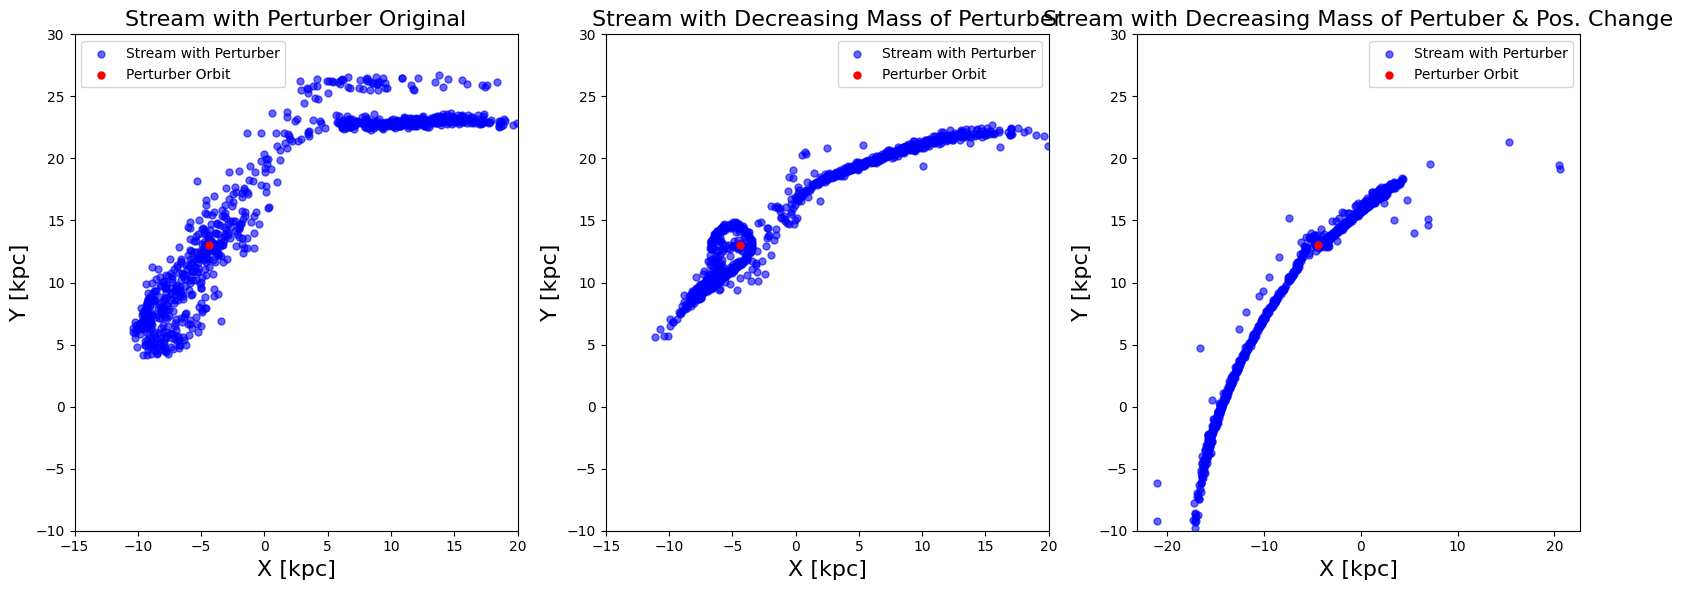

In [19]:
# Extract the x and y positions of the stream and perturber
perturber_xy = orbit_pert[-3][:, :2]        # First 2 columns are x, y positions for the perturber
perturber_xy_og = orbit_pert_og[-3][:, :2]  
perturber_xy_new  = orbit_pert_temp_new[-3][:, :2]  

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Plot with perturber
axs[0].scatter(xv_stream_og[-3][:,0], xv_stream_og[-3][:,1], color='blue', s=25, label='Stream with Perturber', alpha=0.6)
axs[0].scatter(perturber_xy_og[:, 0][-1], perturber_xy_og[:, 1][-1], color='red', s=25, label='Perturber Orbit')
axs[0].set_xlabel('X [kpc]', fontsize=16)
axs[0].set_ylabel('Y [kpc]', fontsize=16)
axs[0].set_title('Stream with Perturber Original', fontsize=16)
axs[0].set_xlim(-15, 20)
axs[0].set_ylim(-10,30)
axs[0].legend()

# Plot with perturber
axs[1].scatter(xv_stream[-3][:,0], xv_stream[-3][:,1], color='blue', s=25, label='Stream with Perturber', alpha=0.6)
axs[1].scatter(perturber_xy[:, 0][-1], perturber_xy[:, 1][-1], color='red', s=25, label='Perturber Orbit')
axs[1].set_xlabel('X [kpc]', fontsize=16)
axs[1].set_ylabel('Y [kpc]', fontsize=16)
axs[1].set_title('Stream with Decreasing Mass of Perturber', fontsize=16)
axs[1].set_xlim(-15, 20)
axs[1].set_ylim(-10,30)
axs[1].legend()

# Plot with perturber
axs[2].scatter(xv_stream_temp_new[-3][:,0], xv_stream_temp_new[-3][:,1], color='blue', s=25, label='Stream with Perturber', alpha=0.6)
axs[2].scatter(perturber_xy_new[:, 0][-1], perturber_xy_new[:, 1][-1], color='red', s=25, label='Perturber Orbit')
axs[2].set_xlabel('X [kpc]', fontsize=16)
axs[2].set_ylabel('Y [kpc]', fontsize=16)
axs[2].set_title('Stream with Decreasing Mass of Pertuber & Pos. Change', fontsize=16)
# axs[2].set_xlim(-15, 20)
axs[2].set_ylim(-10,30)
axs[2].legend()

plt.tight_layout()
plt.show()


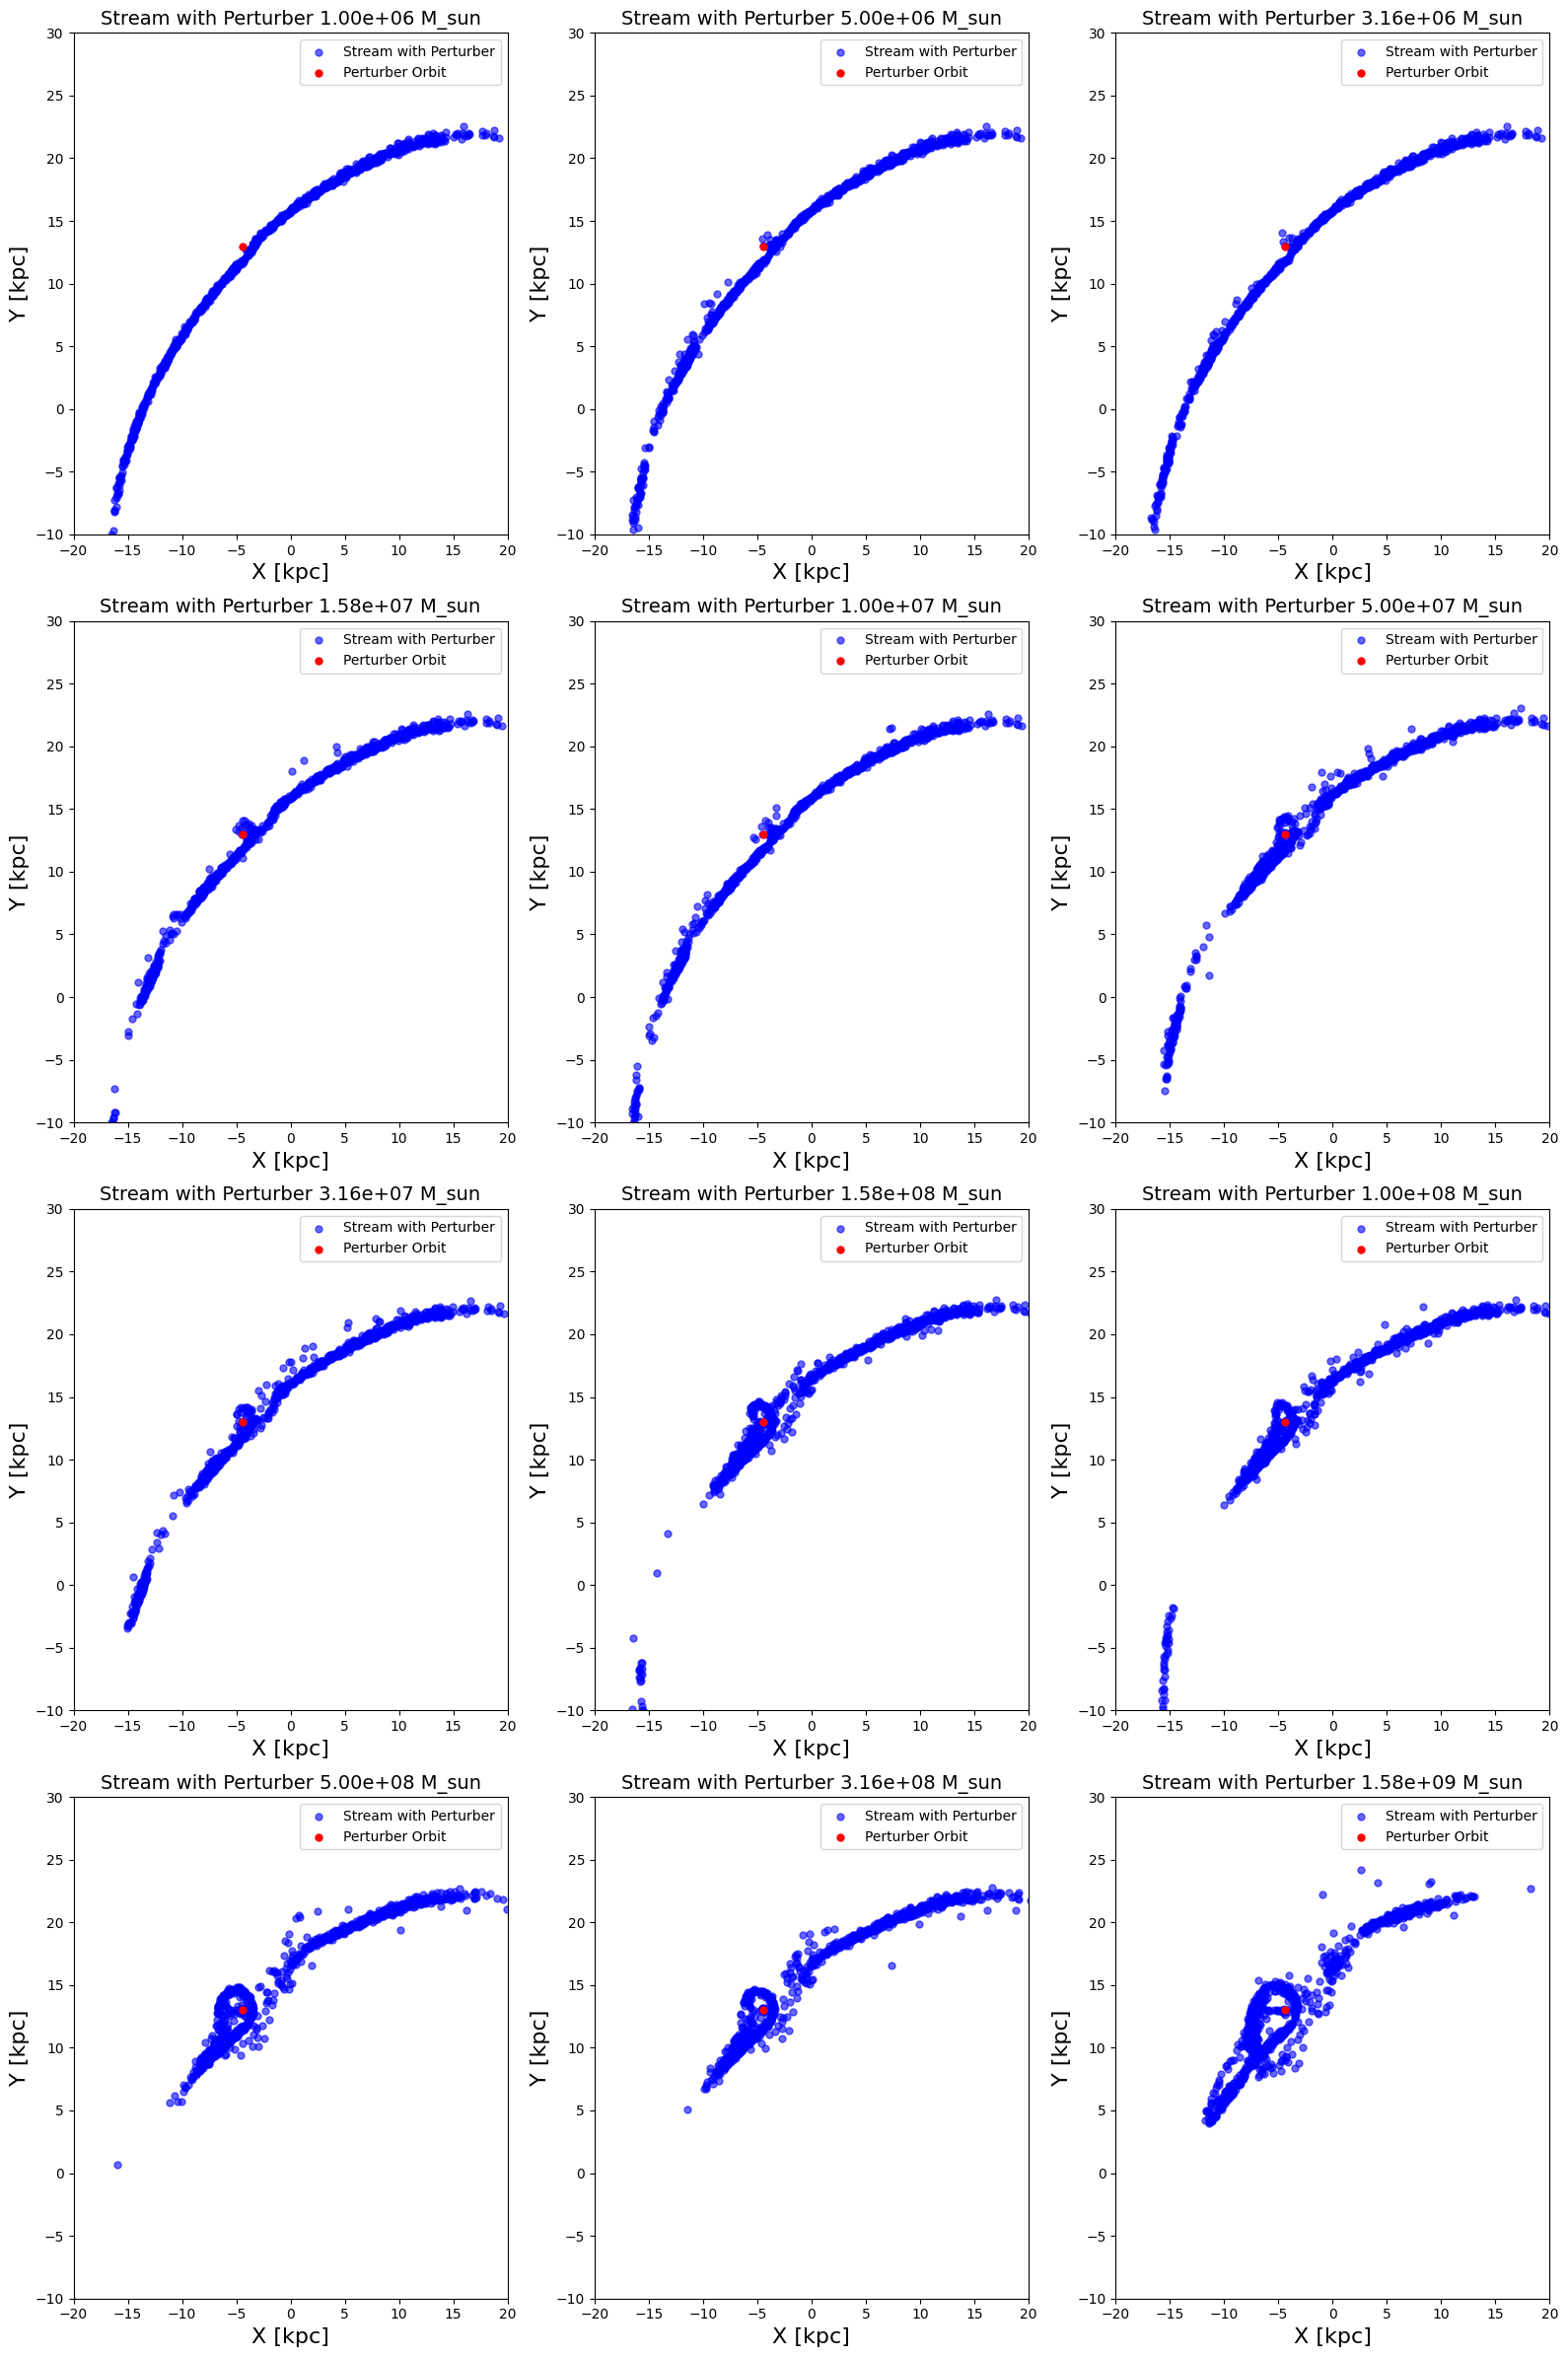

In [20]:
### PLOTS FOR STREAM CHANGING MASS AND SCALE OF PERTURBER OVER TIME ###
fig, axs = plt.subplots(4, 3, figsize=(16, 24))  # Adjusted figsize for better spacing

for i in range(len(pert_masses)):
    perturber_xy = orbit_pert[i][:, :2]  # First 2 columns are x, y positions for the perturber

    # Plot with perturber
    axs[i // 3, i % 3].scatter(xv_stream[i][:,0], xv_stream[i][:,1], color='blue', s=25, label='Stream with Perturber', alpha=0.6)
    axs[i // 3, i % 3].scatter(perturber_xy[:, 0][-1], perturber_xy[:, 1][-1], color='red', s=25, label='Perturber Orbit')
    axs[i // 3, i % 3].set_xlabel('X [kpc]', fontsize=16)
    axs[i // 3, i % 3].set_ylabel('Y [kpc]', fontsize=16)
    axs[i // 3, i % 3].set_title(f'Stream with Perturber {pert_masses[i]:.2e} M_sun', fontsize=14)
    axs[i // 3, i % 3].set_xlim(-20, 20)
    axs[i // 3, i % 3].set_ylim(-10, 30)
    axs[i // 3, i % 3].legend()

plt.tight_layout()
plt.show()




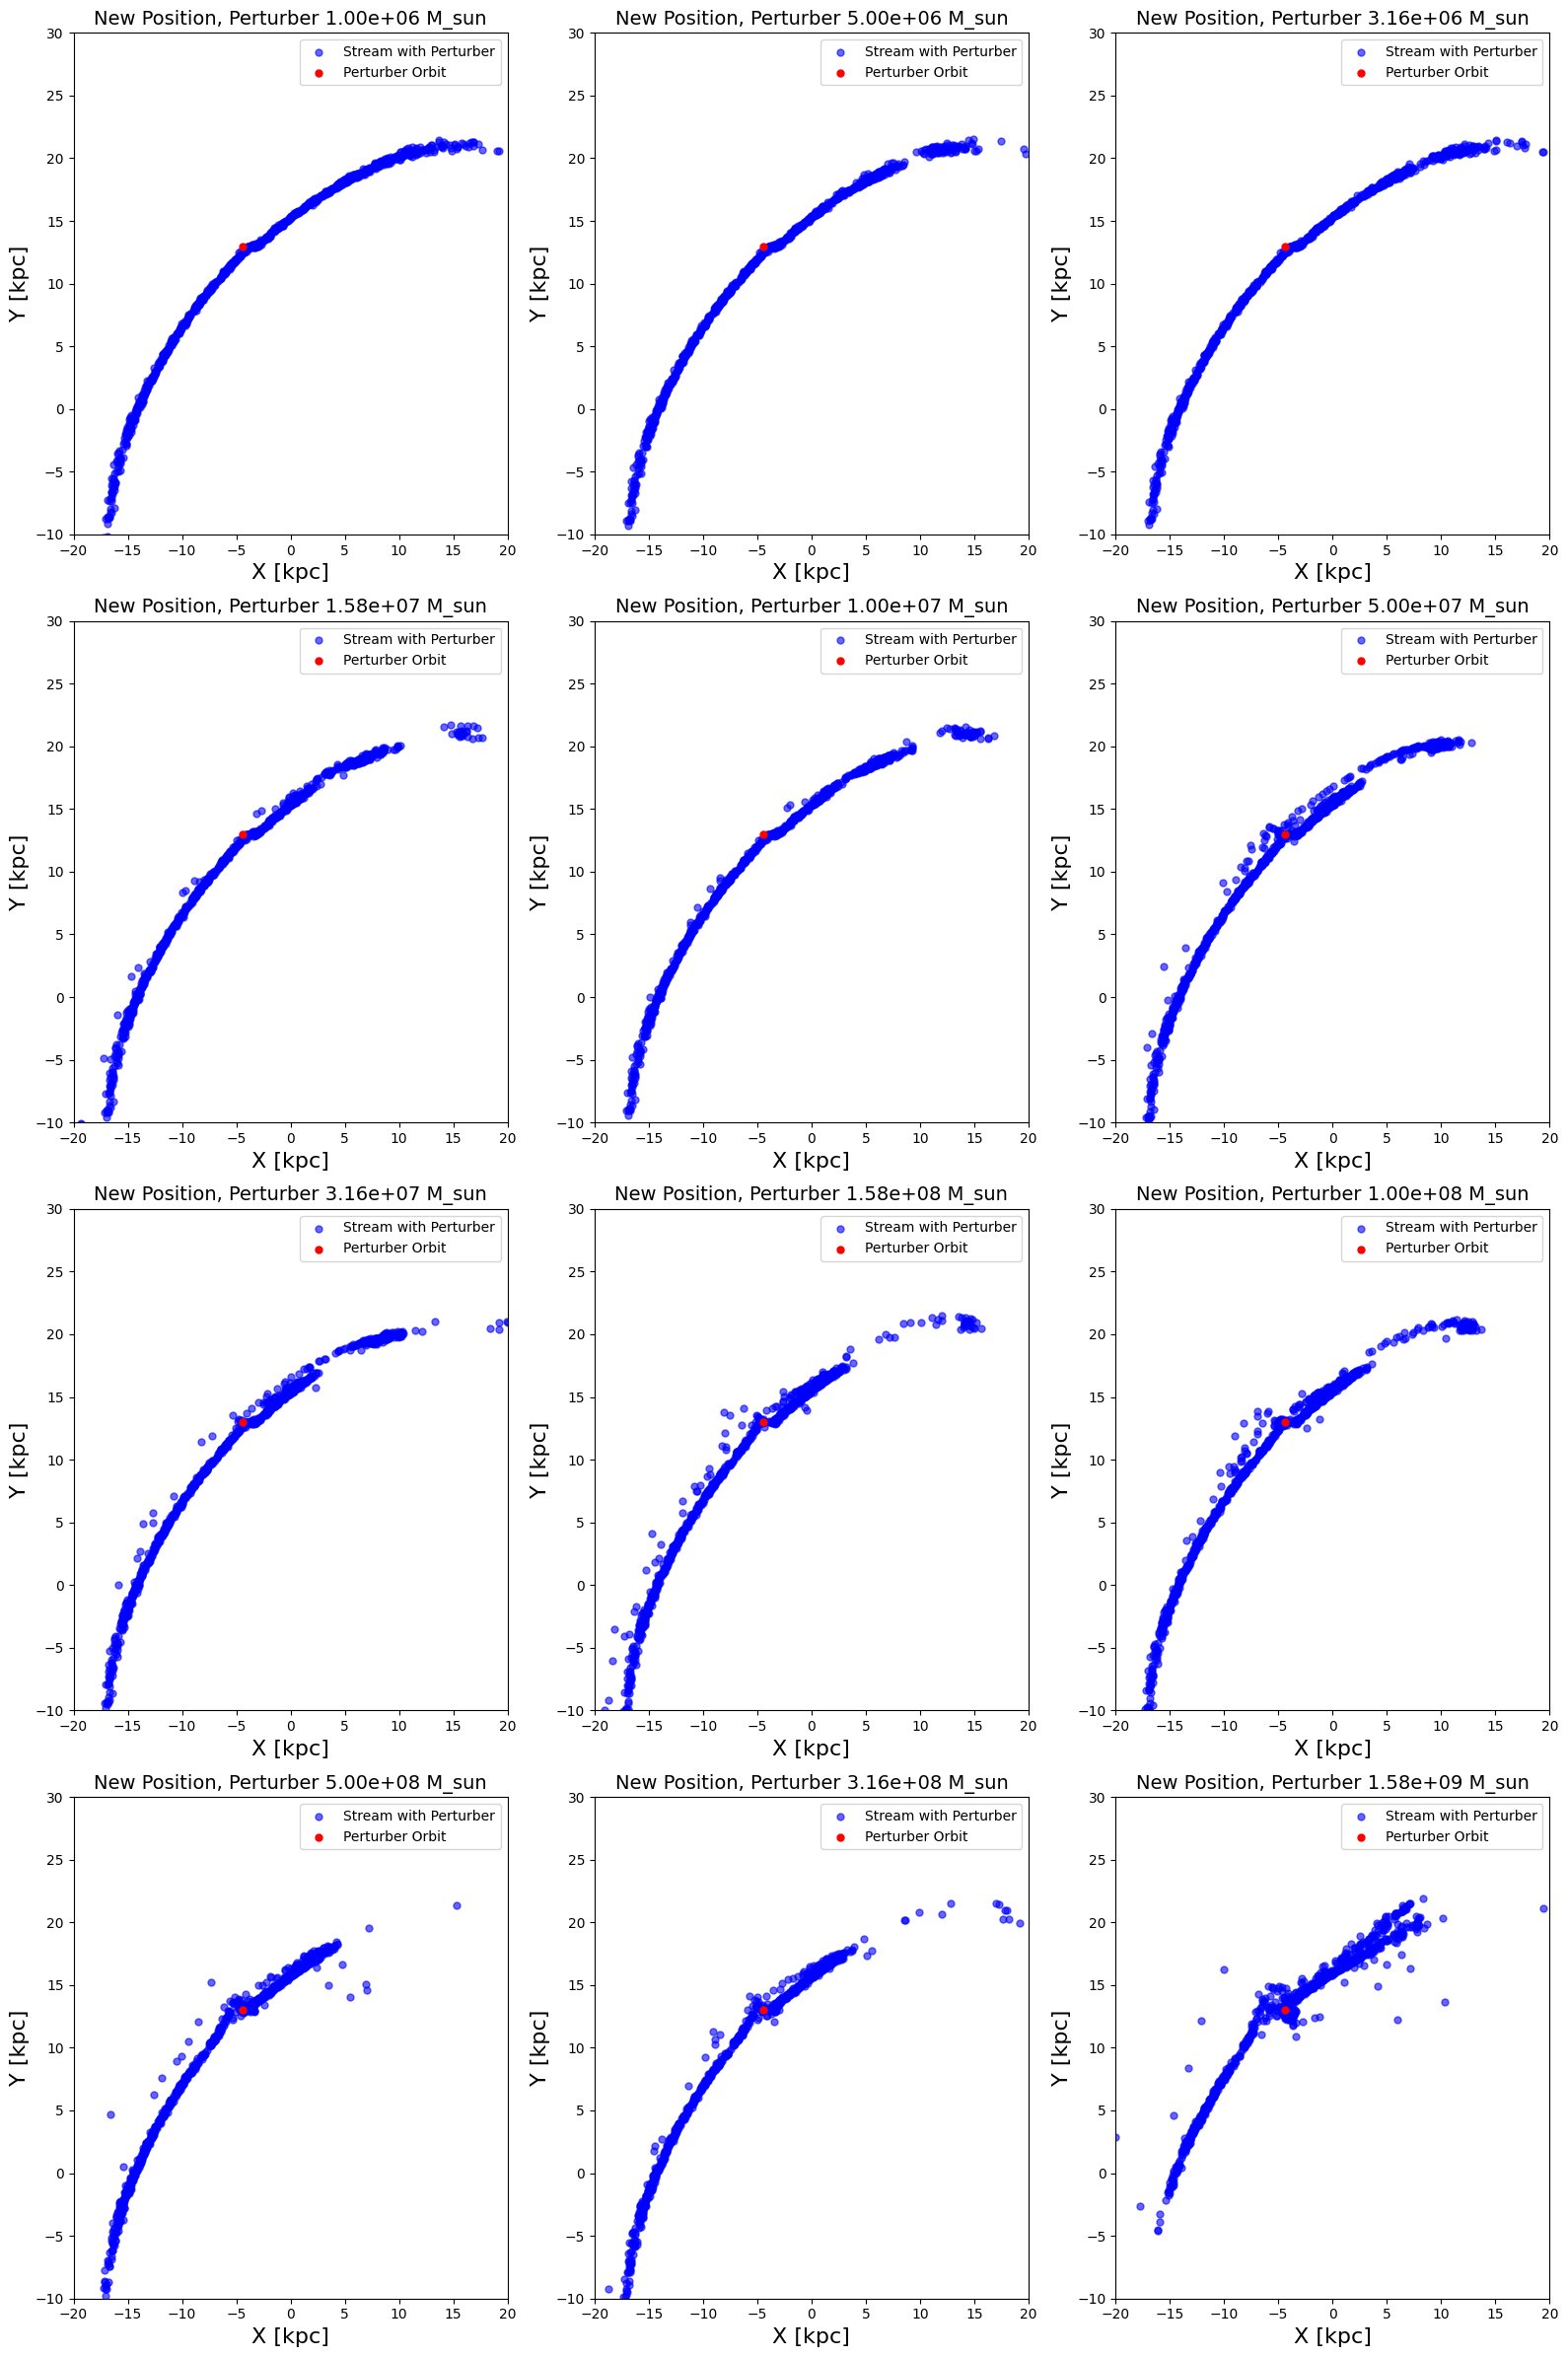

In [21]:
### PLOTS FOR STREAM CHANGING MASS AND SCALE OF PERTURBER OVER TIME ###
fig, axs = plt.subplots(4, 3, figsize=(16, 24))  # Adjusted figsize for better spacing

for i in range(len(pert_masses)):
    perturber_xy_temp_new = orbit_pert_temp_new[i][:, :2]  # First 2 columns are x, y positions for the perturber

    # Plot with perturber
    axs[i // 3, i % 3].scatter(xv_stream_temp_new[i][:,0], xv_stream_temp_new[i][:,1], color='blue', s=25, label='Stream with Perturber', alpha=0.6)
    axs[i // 3, i % 3].scatter(perturber_xy_temp_new[:, 0][-1], perturber_xy_temp_new[:, 1][-1], color='red', s=25, label='Perturber Orbit')
    axs[i // 3, i % 3].set_xlabel('X [kpc]', fontsize=16)
    axs[i // 3, i % 3].set_ylabel('Y [kpc]', fontsize=16)
    axs[i // 3, i % 3].set_title(f'New Position, Perturber {pert_masses[i]:.2e} M_sun', fontsize=14)
    axs[i // 3, i % 3].set_xlim(-20, 20)
    axs[i // 3, i % 3].set_ylim(-10, 30)
    axs[i // 3, i % 3].legend()

plt.tight_layout()
plt.show()

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_70474/2101784526.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b', label='Observed')


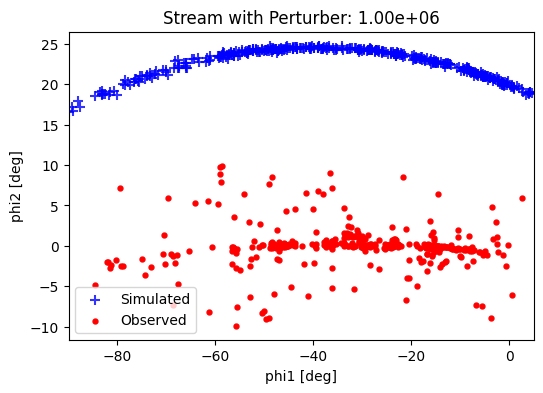

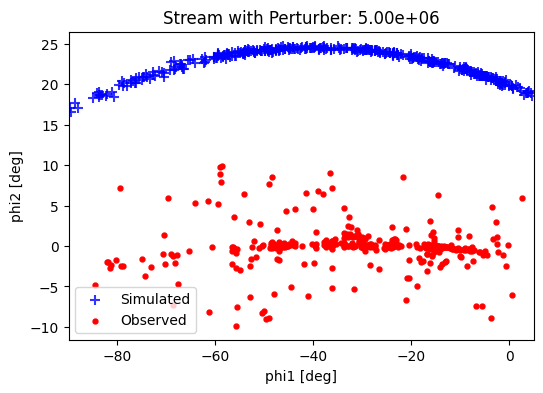

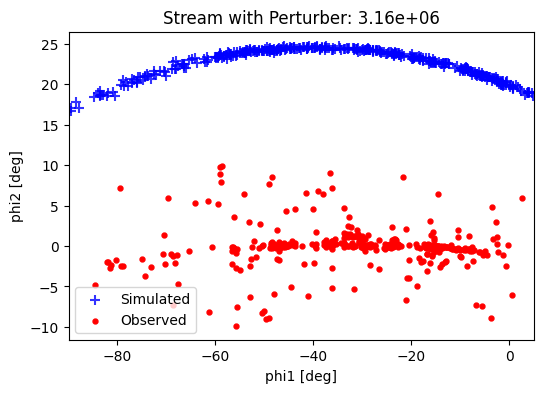

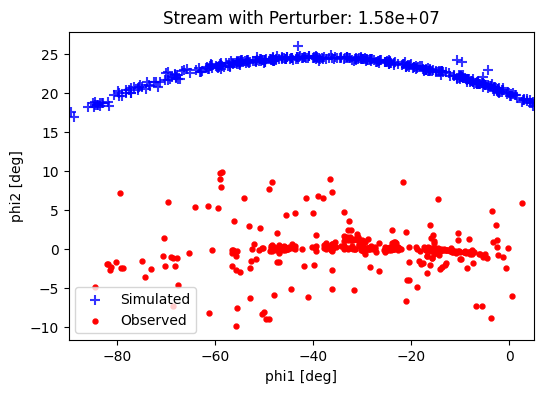

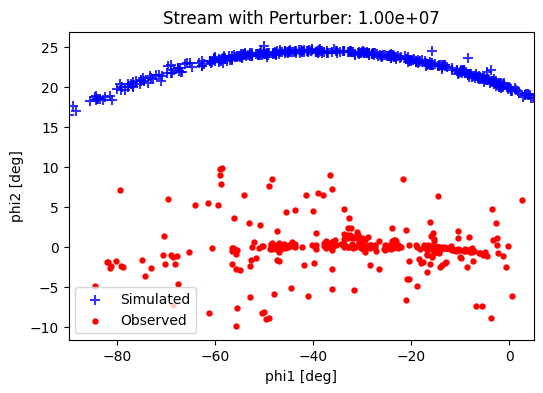

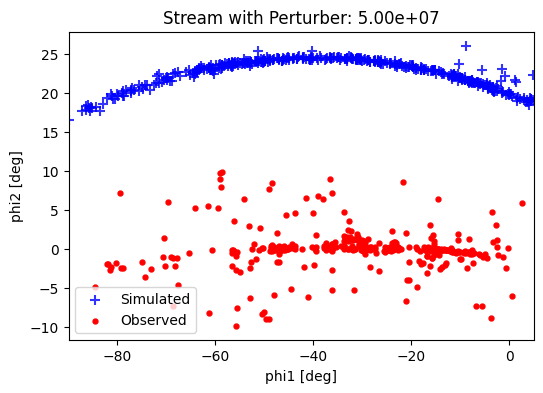

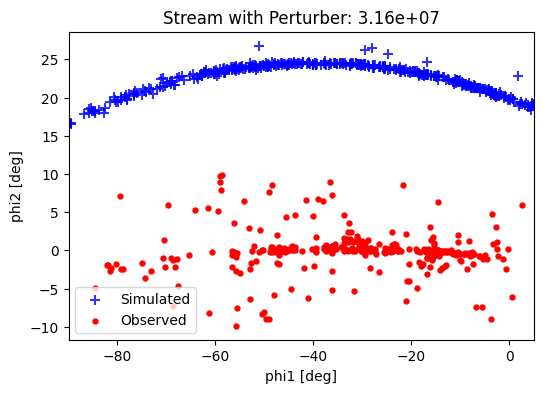

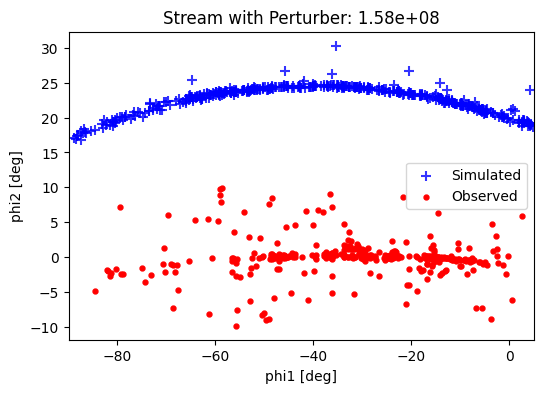

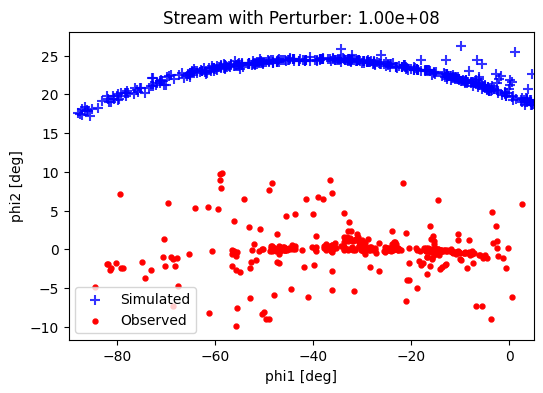

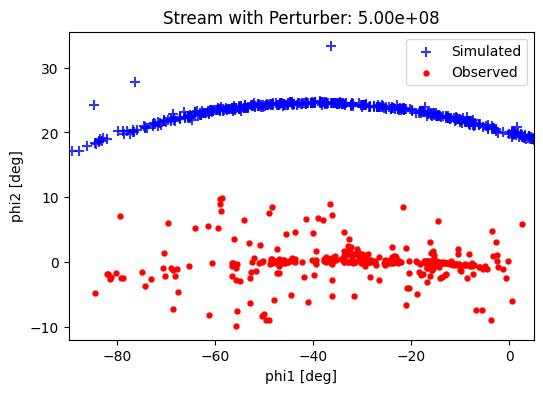

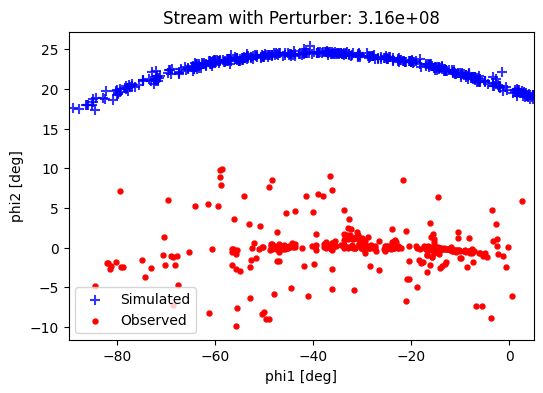

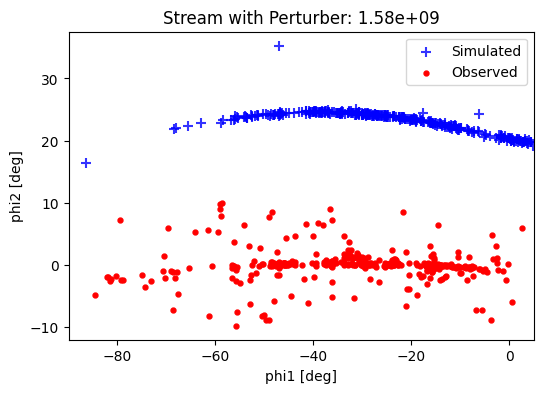

In [22]:
for i in range(len(pert_masses)):  
    # Extract the X, Y, Z positions from xv_stream
    x = xv_stream_temp_new[i][:,0] * u.kpc  # Assuming positions are in kpc
    y = xv_stream_temp_new[i][:,1] * u.kpc
    z = xv_stream_temp_new[i][:,2] * u.kpc
    
    # Create a SkyCoord object using CartesianRepresentation for Galactic coordinates
    stream_galactic = SkyCoord(CartesianRepresentation(x=x, y=y, z=z), frame=Galactic())
    
    # Transform to ICRS first
    stream_icrs = stream_galactic.transform_to(ICRS())
    
    # Transform to the GD1Koposov10 frame
    gd1_sim = stream_icrs.transform_to(gc.GD1Koposov10())

    x_range = (gd1_sim.phi1 >= -90 * u.deg) & (gd1_sim.phi1 <= 5 * u.deg)
    plt.figure(figsize=(6, 4))
    plt.scatter(gd1_sim.phi1[x_range], gd1_sim.phi2[x_range], marker='+', s=50, color='blue', alpha=0.8, label='Simulated')
    plt.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b', label='Observed')
    plt.xlim(-90, 5.)
    plt.legend(loc='best')
    plt.xlabel('phi1 [deg]')
    plt.ylabel('phi2 [deg]')
    plt.title(f'Stream with Perturber: {pert_masses[i]:.2e}')



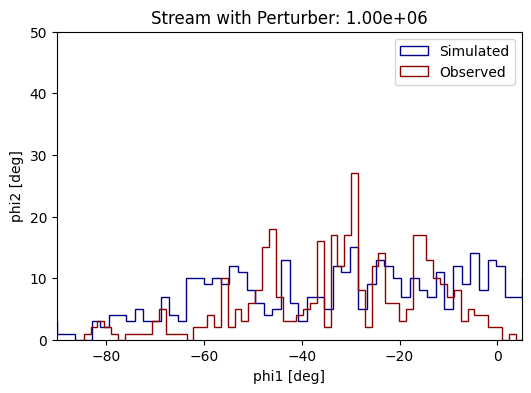

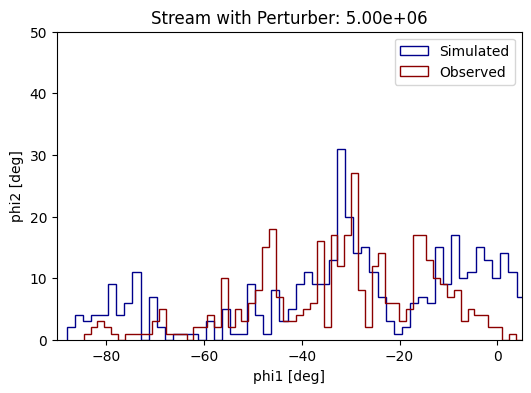

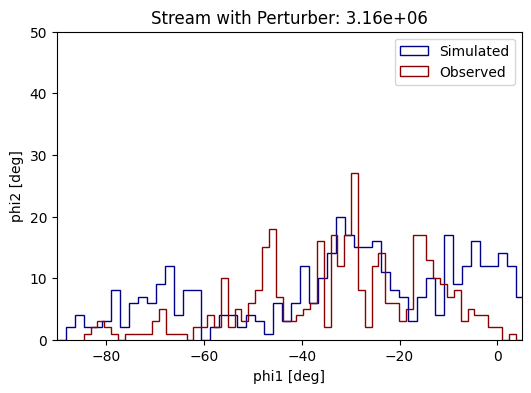

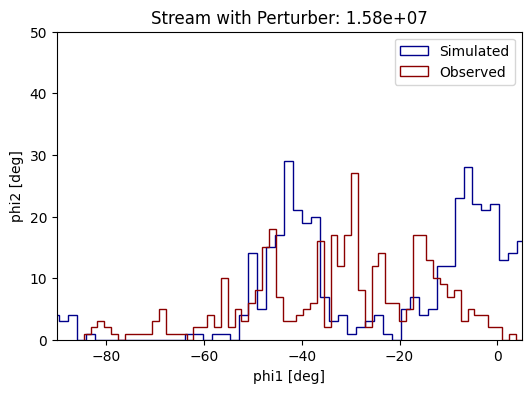

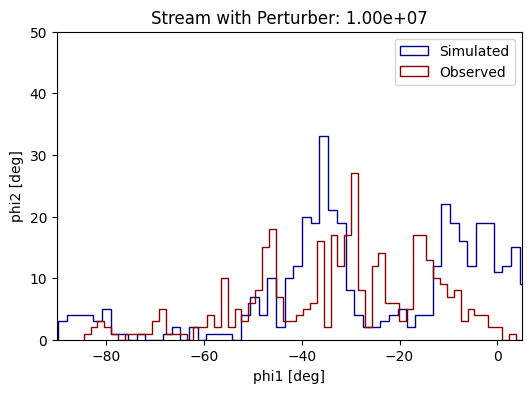

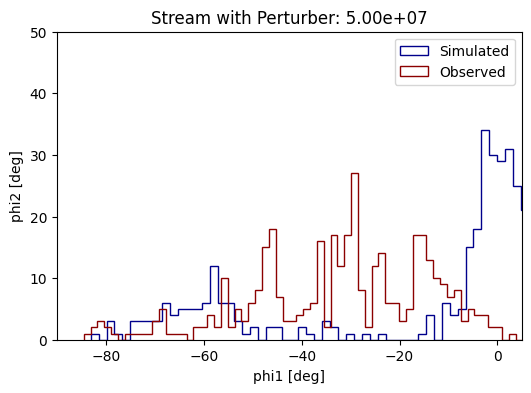

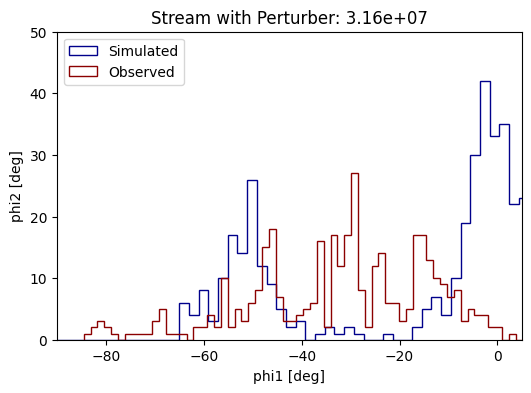

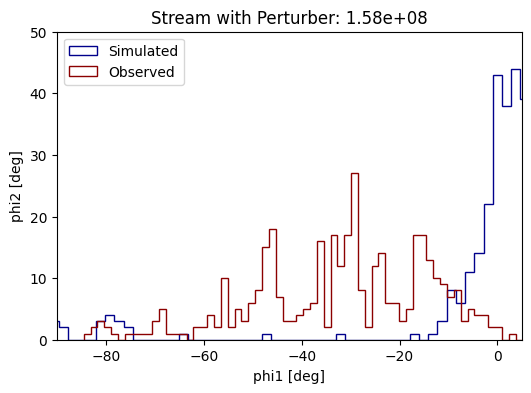

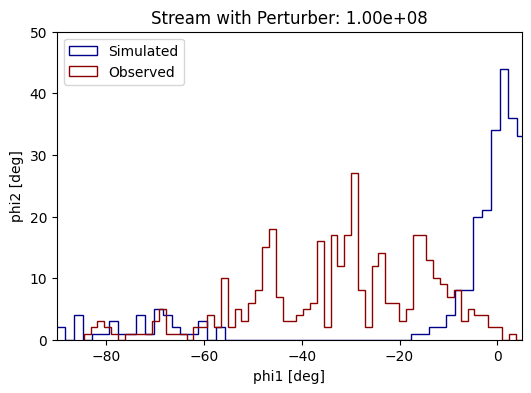

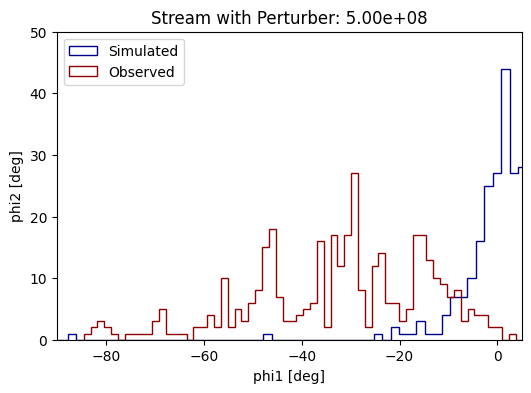

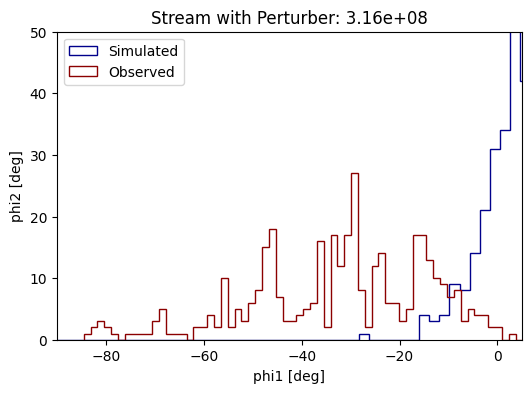

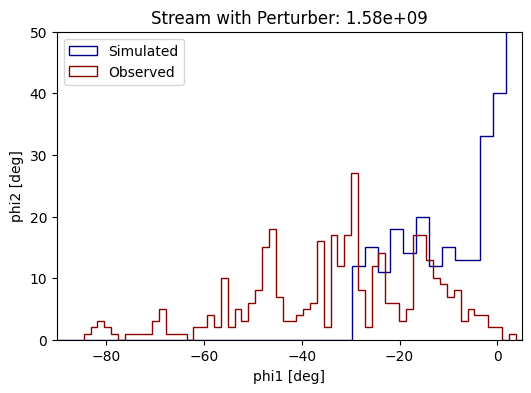

In [23]:
for i in range(len(pert_masses)):  
    # Extract the X, Y, Z positions from xv_stream
    x = xv_stream[i][:,0] * u.kpc  # Assuming positions are in kpc
    y = xv_stream[i][:,1] * u.kpc
    z = xv_stream[i][:,2] * u.kpc
    
    # Create a SkyCoord object using CartesianRepresentation for Galactic coordinates
    stream_galactic = SkyCoord(CartesianRepresentation(x=x, y=y, z=z), frame=Galactic())
    
    # Transform to ICRS first
    stream_icrs = stream_galactic.transform_to(ICRS())
    
    # Transform to the GD1Koposov10 frame
    gd1_sim = stream_icrs.transform_to(gc.GD1Koposov10())

    x_range = (gd1_sim.phi1 >= -90 * u.deg) & (gd1_sim.phi1 <= 5 * u.deg)
    plt.figure(figsize=(6, 4))
    plt.hist(gd1_sim.phi1, bins=100, histtype='step', color='darkblue', label='Simulated')
    plt.hist(phi1, bins=100, histtype='step', color='darkred', label='Observed')
    plt.xlim(-90, 5.)
    plt.ylim(0, 50)
    plt.legend(loc='best')
    plt.xlabel('phi1 [deg]')
    plt.ylabel('phi2 [deg]')
    plt.title(f'Stream with Perturber: {pert_masses[i]:.2e}')



# plot the rot curve 

r*dphi/dr 



#check agama to get the derivtive of the potential. evaluated at 

# change the density norm and see how it compares to the one from composite potential 



#run a shorter time and see if it runs better 


1) introudce the poertuber at the beginning of the simulation where there is the new location of the progenitor. 

2) decrease the mass of the perturber, how to get the time 

3) algorthm to count how many gaps in the stream occur 


email neil about whta class to take on bayesian analysis 


- mass loss rate - oleg 